In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
# License: MIT

# k-means analysis of HadISST SST anomalies

In this notebook we perform a k-means clustering analysis of SST anomalies
computed from the HadISST dataset.

## Packages

In [59]:
%matplotlib inline

import itertools
import os
import time

import cartopy.crs as ccrs
import cmocean
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import xarray as xr

from cartopy.util import add_cyclic_point
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import MDS, TSNE

## Analysis parameters

In [4]:
TIME_NAME = 'time'
LAT_NAME = 'latitude'
LON_NAME = 'longitude'
ANOMALY_NAME = 'sst_anom'
STANDARDIZED_ANOMALY_NAME = 'sst_std_anom'

# First and last years to retain for analysis
START_YEAR = 1870
END_YEAR = 2018

# First and last years of climatology base period
BASE_PERIOD_START_YEAR = 1981
BASE_PERIOD_END_YEAR = 2010

# Order of trend removed from anomalies
ANOMALY_TREND_ORDER = 1

# Zonal extents of analysis region
MIN_LATITUDE = -45.5
MAX_LATITUDE = 45.5

# Weighting used for EOFs
LAT_WEIGHTS = 'scos'
RESTRICT_TO_CLIMATOLOGY_BASE_PERIOD = False

# Number of random restarts to use
N_INIT = 100

# If cross-validation is used, number of cross-validation folds
N_FOLDS = 10

# Reference distribution used for gap statistic
REFERENCE = 'pca'

## File paths

In [5]:
def get_kmeans_output_filename(input_file, lat_weights, n_components, n_init, gap_reference=REFERENCE, cross_validate=False, n_folds=N_FOLDS):
    """Get k-means output file corresponding to a given input file."""
    
    basename, ext = os.path.splitext(input_file)
    suffix = 'kmeans.{}.k{:d}.n_init{:d}.{}_gap'.format(lat_weights, n_components, n_init, gap_reference)
    if cross_validate:
        suffix = '.'.join([suffix, 'n_folds{:d}'.format(n_folds)])
        
    return '.'.join([basename, suffix]) + ext

In [6]:
PROJECT_DIR = os.path.join(os.getenv('HOME'), 'projects', 'convex-dim-red-expts')
BIN_DIR = os.path.join(PROJECT_DIR, 'bin')
BASE_RESULTS_DIR = os.path.join(PROJECT_DIR, 'results')
RESULTS_DIR = os.path.join(BASE_RESULTS_DIR, 'hadisst', 'nc')
CSV_DIR = os.path.join(BASE_RESULTS_DIR, 'hadisst', 'csv')
PLOTS_DIR = os.path.join(BASE_RESULTS_DIR, 'hadisst', 'plt')

if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

SST_ANOM_INPUT_FILE = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.nc'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER))
SST_STD_ANOM_INPUT_FILE = os.path.join(RESULTS_DIR, 'HadISST_sst.std_anom.{:d}_{:d}.trend_order{:d}.nc'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER))

if not os.path.exists(SST_ANOM_INPUT_FILE):
    raise RuntimeError("Input data file '%s' does not exist" % SST_ANOM_INPUT_FILE)
    
if not os.path.exists(SST_STD_ANOM_INPUT_FILE):
    raise RuntimeError("Input data file '%s' does not exist" % SST_STD_ANOM_INPUT_FILE)

## k-means clustering of SST anomalies

The k-means clustering is first run on the initial (unstandardized) SST anomalies.
The cluster centroids are fitted on the first 90% of the dataset, with the remaining
10% of the dataset used to get a rough estimate of out-of-sample RMSE.

The clustering is done with k = 1, ..., 20 clusters, each time restarting the algorithm
multiple times with different initial centroids to try to reduce trapping in local
minima. To assess the extent to which a given number of clusters is suited for the data,
we compute the gap statistic proposed by Tibshirani et al. To compare with the
EOFs computed via PCA, the anomalies are latitude weighted by the square root of the
cosine of the latitude.

As the whole process is trivially parallelizable for each choice of k, for convenience
the actual fit is broken out into a script (see bin/run_hadisst_kmeans.py) that can
be run independently as separate jobs:

In [95]:
with open(os.path.join(BIN_DIR, 'run_hadisst_kmeans.py')) as ifs:
    for line in ifs:
        print(line.strip('\n'))

"""
Run k-means on HadISST SST anomalies.
"""

# License: MIT

from __future__ import absolute_import, division, print_function

import argparse
import time

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import check_random_state
import xarray as xr

from convex_dim_red import gap_statistic

LAT_NAME = 'latitude'
LON_NAME = 'longitude'
TIME_NAME = 'time'
ANOMALY_NAME = 'sst_anom'
STD_ANOMALY_NAME = 'sst_std_anom'

# First and last years to retain for analysis
START_YEAR = 1870
END_YEAR = 2018

# Zonal extents of analysis region
MIN_LATITUDE = -45.5
MAX_LATITUDE = 45.5


def parse_cmd_line_args():
    """Parse command line arguments."""

    parser = argparse.ArgumentParser(
        description='Run k-means on HadISST SST anomalies')

    parser.add_argument('input_file',
                        help='input file containing SST anomalies')
    parser.add_argument(

In [8]:
max_n_components = 20

sst_k = []
sst_gap = []
sst_gap_sk = []

for i in range(1, max_n_components + 1):

    output_file = get_kmeans_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, i, N_INIT)
    
    with xr.open_dataset(output_file) as ds:
        
        sst_k.append(ds.sizes['component'])
        sst_gap.append(float(ds.attrs['gap_statistic']))
        sst_gap_sk.append(float(ds.attrs['gap_sk']))
        
sst_k = np.array(sst_k)
sst_gap = np.array(sst_gap)
sst_gap_sk = np.array(sst_gap_sk)

gap_criterion = None
for i in range(max_n_components - 1):
    if sst_gap[i] >= sst_gap[i + 1] - sst_gap_sk[i + 1]:
        gap_criterion = sst_gap[i]
        
if gap_criterion is None:
    print('No k satisfying gap criterion')
else:
    print('Cluster selected by gap criterion = ', gap_criterion)

gap_output_file = 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.kmeans.{}.n_init{:d}.gap.csv'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, N_INIT)
gap_output_file = os.path.join(CSV_DIR, gap_output_file)

gap_data = np.zeros((sst_k.shape[0], 3))
gap_data[:, 0] = sst_k
gap_data[:, 1] = sst_gap
gap_data[:, 2] = sst_gap_sk

header = 'n_components,gap_statistic,gap_sk'
fmt = '%d,%16.8e,%16.8e'

np.savetxt(gap_output_file, gap_data, header=header, fmt=fmt)

Cluster selected by gap criterion =  1.32758567


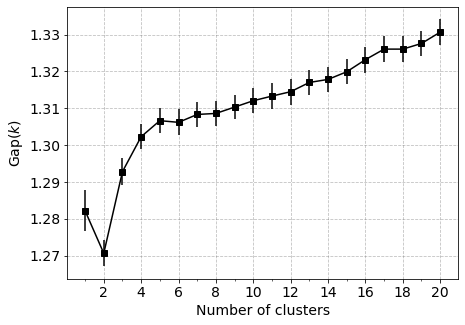

In [9]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.errorbar(sst_k, sst_gap, yerr=sst_gap_sk, fmt='k', marker='s')

ax.grid(ls='--', color='gray', alpha=0.5)

ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('$\mathrm{Gap}(k)$', fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.tick_params(labelsize=14)

output_file = 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.kmeans.{}.n_init{:d}.{}_gap.gap.pdf'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, N_INIT, REFERENCE)
output_file = os.path.join(PLOTS_DIR, output_file)

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

In [10]:
max_n_components = 20

sst_k = []
sst_train_cost = []
sst_train_rmse = []
sst_test_cost = []
sst_test_rmse = []

for i in range(1, max_n_components + 1):

    output_file = get_kmeans_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, i, N_INIT)
    
    with xr.open_dataset(output_file) as ds:
        
        sst_k.append(ds.sizes['component'])
        sst_train_cost.append(float(ds.attrs['training_set_cost']))
        sst_train_rmse.append(float(ds.attrs['training_set_rmse']))
        sst_test_cost.append(float(ds.attrs['test_set_cost']))
        sst_test_rmse.append(float(ds.attrs['test_set_rmse']))
        
sst_k = np.array(sst_k)
sst_train_cost = np.array(sst_train_cost)
sst_train_rmse = np.array(sst_train_rmse)
sst_test_cost = np.array(sst_test_cost)
sst_test_rmse = np.array(sst_test_rmse)

cost_output_file = 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.kmeans.{}.n_init{:d}.{}_gap.cost.csv'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, N_INIT, REFERENCE)
cost_output_file = os.path.join(CSV_DIR, cost_output_file)

cost_data = np.zeros((sst_k.shape[0], 5))
cost_data[:, 0] = sst_k
cost_data[:, 1] = sst_train_cost
cost_data[:, 2] = sst_train_rmse
cost_data[:, 3] = sst_test_cost
cost_data[:, 4] = sst_test_rmse

header = 'n_components,training_set_cost,training_set_rmse,test_set_cost,test_set_rmse'
fmt = '%d,%16.8e,%16.8e,%16.8e,%16.8e'

np.savetxt(cost_output_file, cost_data, header=header, fmt=fmt)

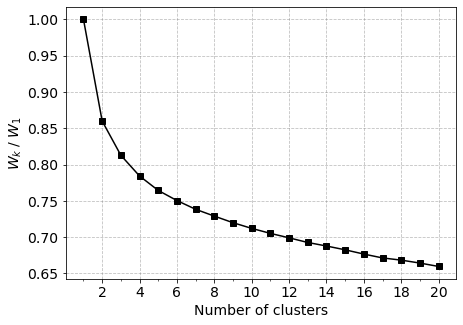

In [11]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(sst_k, sst_train_cost / sst_train_cost[0], 'k-', marker='s', label='Training set cost')
#ax.plot(sst_k, sst_test_cost, 'b:', label='Test set cost')

ax.grid(ls='--', color='gray', alpha=0.5)
#ax.legend(fontsize=14)

ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('$W_k \; / \; W_1$', fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.tick_params(labelsize=14)

output_file = 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.kmeans.{}.n_init{:d}.{}_gap.wk.pdf'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, N_INIT, REFERENCE)
output_file = os.path.join(PLOTS_DIR, output_file)

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

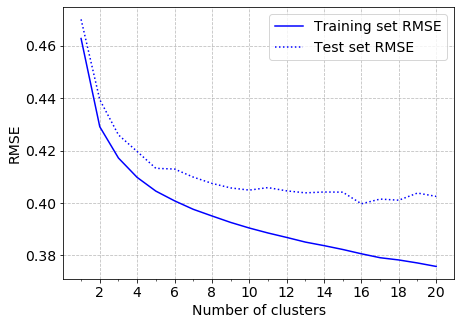

In [12]:
fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

ax.plot(sst_k, sst_train_rmse, 'b-', label='Training set RMSE')
ax.plot(sst_k, sst_test_rmse, 'b:', label='Test set RMSE')

ax.grid(ls='--', color='gray', alpha=0.5)
ax.legend(fontsize=14)

ax.set_xlabel('Number of clusters', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
ax.tick_params(labelsize=14)

plt.show()

plt.close()

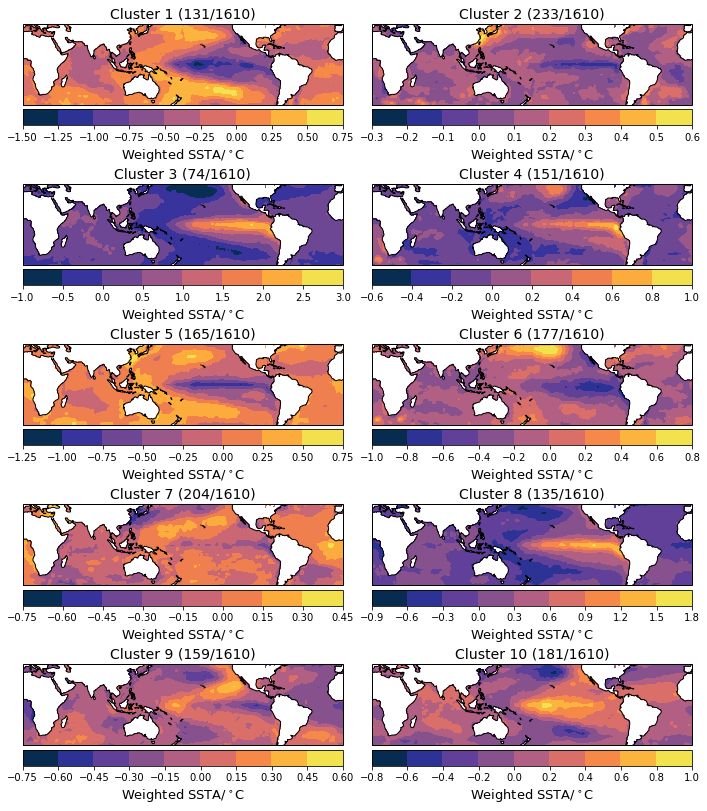

In [13]:
n_components = 10
output_file = get_kmeans_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, N_INIT)

kmeans_ds = xr.open_dataset(output_file)

components = kmeans_ds['component'].values
n_samples = kmeans_ds.sizes[TIME_NAME]

projection = ccrs.PlateCarree(central_longitude=180)
wrap_lon = True

cmap = cmocean.cm.thermal

component_vmins = np.empty(n_components)
vmin = None
for i, component in enumerate(components):
    component_vmin = kmeans_ds['dictionary'].sel(component=component).min().item()
    if vmin is None or component_vmin < vmin:
        vmin = component_vmin

component_vmins[:] = vmin

component_vmaxs = np.empty(n_components)
vmax = None
for i, component in enumerate(components):
    component_vmax = kmeans_ds['dictionary'].sel(component=component).max().item()
    if vmax is None or component_vmax > vmax:
        vmax = component_vmax

component_vmaxs[:] = vmax

ncols = 2 if n_components % 2 == 0 else 3
nrows = int(np.ceil(n_components / ncols))
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

fig = plt.figure(constrained_layout=False, figsize=(6 * ncols, 3 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.09, hspace=0.12,
                       height_ratios=height_ratios)

lat = kmeans_ds[LAT_NAME]
lon = kmeans_ds[LON_NAME]

row_index = 0
col_index = 0
for i, component in enumerate(components):
    centroid_data = kmeans_ds['dictionary'].sel(component=component).values
    component_size = np.sum(kmeans_ds['weights'].sel(component=component)).item()

    if wrap_lon:
        centroid_data, centroid_lon = add_cyclic_point(centroid_data, coord=lon)

    lon_grid, lat_grid = np.meshgrid(centroid_lon, lat)

    ax = fig.add_subplot(gs[row_index, col_index], projection=projection)

    ax.coastlines()
    ax.set_global()

    ax_vmin = component_vmins[i]
    ax_vmax = component_vmaxs[i]

    cs = ax.contourf(lon_grid, lat_grid, centroid_data, # vmin=ax_vmin, vmax=ax_vmax,
                   cmap=cmap, transform=ccrs.PlateCarree())

    cb = fig.colorbar(cs, pad=0.03, orientation='horizontal')
    cb.set_label(r'Weighted SSTA/${}^\circ$C', fontsize=13)

    ax.set_ylim([MIN_LATITUDE, MAX_LATITUDE])

    ax.set_title('Cluster {} ({:d}/{:d})'.format(component + 1, int(component_size), int(n_samples)), fontsize=14)
    ax.set_aspect('equal')
    fig.canvas.draw()

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1

output_file = os.path.join(PLOTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.kmeans.{}.k{:d}.n_init{:d}.{}_gap.centroids.unsorted.pdf'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS,
    n_components, N_INIT, REFERENCE))

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

kmeans_ds.close()

In [14]:
def to_1d_array(da):
    """Convert DataArray to flat array."""

    flat_data = np.ravel(da.values)

    missing_features = np.isnan(flat_data)

    return flat_data[np.logical_not(missing_features)]


def pattern_correlation(state, eof):
    """Calculate pattern correlation between state and EOF."""

    flat_state = to_1d_array(state)
    flat_eof = to_1d_array(eof)

    data = np.vstack([flat_state, flat_eof])

    r = np.corrcoef(data, rowvar=True)

    return r[0, 1]


def sort_states(ds, eofs_reference_file):
    """Sort states according to pattern correlation with EOFs."""

    n_components = ds.sizes['component']

    sort_order = []
    with xr.open_dataset(eofs_reference_file) as eofs_ds:

        n_eofs = eofs_ds.sizes['component']

        for i in range(n_eofs):
            correlations = np.empty((n_components,))

            for k in range(n_components):
                correlations[k] = pattern_correlation(
                    ds['dictionary'].sel(component=k),
                    eofs_ds['EOFs'].sel(component=i))

            ordering = np.argsort(-np.abs(correlations))
            for k in range(n_components):
                if ordering[k] not in sort_order:
                    sort_order.append(ordering[k])
                    break

            if np.size(sort_order) == n_components:
                break

    assert len(sort_order) <= n_components
    assert np.size(np.unique(sort_order)) == np.size(sort_order)

    if len(sort_order) < n_components:
        unassigned = [i for i in range(n_components) if i not in sort_order]
        sort_order += unassigned

    assert len(sort_order) == n_components
    assert np.size(np.unique(sort_order)) == np.size(sort_order)

    sorted_ds = xr.zeros_like(ds)
    for i in range(n_components):
        sorted_ds = xr.where(sorted_ds['component'] == i,
                             ds.sel(component=sort_order[i]), sorted_ds)

    for a in ds.attrs:
        sorted_ds.attrs[a] = ds.attrs[a]

    return sorted_ds

cos(theta) =  <xarray.DataArray ()>
array(0.99865019)
Coordinates:
    component  int32 0


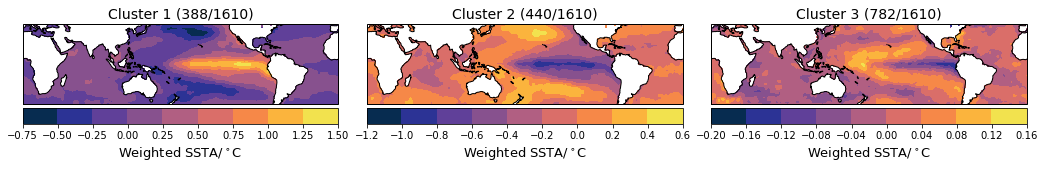

In [94]:
n_components = 3
output_file = get_kmeans_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, N_INIT)

kmeans_ds = xr.open_dataset(output_file)

eofs_reference_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))

kmeans_ds = sort_states(kmeans_ds, eofs_reference_file)

# Calculate angle between leading principal axis and vector between first and second cluster
# centroids
if n_components > 1:
    with xr.open_dataset(eofs_reference_file) as eofs_ds:
        first_eof = eofs_ds['EOFs'].sel(component=0).squeeze().fillna(0)
        
        centroid_difference = (kmeans_ds['dictionary'].sel(component=0) - kmeans_ds['dictionary'].sel(component=1)).squeeze().fillna(0)
        
        overlap = first_eof.dot(centroid_difference) / np.sqrt(first_eof.dot(first_eof) * centroid_difference.dot(centroid_difference))
        
        print('cos(theta) = ', overlap)

components = kmeans_ds['component'].values
n_samples = kmeans_ds.sizes[TIME_NAME]

projection = ccrs.PlateCarree(central_longitude=180)
wrap_lon = True

cmap = cmocean.cm.thermal

component_vmins = np.empty(n_components)
vmin = None
for i, component in enumerate(components):
    component_vmin = kmeans_ds['dictionary'].sel(component=component).min().item()
    if vmin is None or component_vmin < vmin:
        vmin = component_vmin

component_vmins[:] = vmin

component_vmaxs = np.empty(n_components)
vmax = None
for i, component in enumerate(components):
    component_vmax = kmeans_ds['dictionary'].sel(component=component).max().item()
    if vmax is None or component_vmax > vmax:
        vmax = component_vmax

component_vmaxs[:] = vmax

ncols = 2 if n_components % 2 == 0 else 3
nrows = int(np.ceil(n_components / ncols))
height_ratios = np.ones((nrows + 1))
height_ratios[-1] = 0.1

fig = plt.figure(constrained_layout=False, figsize=(6 * ncols, 3 * nrows))

gs = gridspec.GridSpec(ncols=ncols, nrows=nrows + 1, figure=fig,
                       wspace=0.09, hspace=0.12,
                       height_ratios=height_ratios)

lat = kmeans_ds[LAT_NAME]
lon = kmeans_ds[LON_NAME]

row_index = 0
col_index = 0
for i, component in enumerate(components):
    centroid_data = kmeans_ds['dictionary'].sel(component=component).values
    component_size = np.sum(kmeans_ds['weights'].sel(component=component)).item()

    if wrap_lon:
        centroid_data, centroid_lon = add_cyclic_point(centroid_data, coord=lon)

    lon_grid, lat_grid = np.meshgrid(centroid_lon, lat)

    ax = fig.add_subplot(gs[row_index, col_index], projection=projection)

    ax.coastlines()
    ax.set_global()

    ax_vmin = component_vmins[i]
    ax_vmax = component_vmaxs[i]

    cs = ax.contourf(lon_grid, lat_grid, centroid_data, # vmin=ax_vmin, vmax=ax_vmax,
                   cmap=cmap, transform=ccrs.PlateCarree())

    cb = fig.colorbar(cs, pad=0.03, orientation='horizontal')
    cb.set_label(r'Weighted SSTA/${}^\circ$C', fontsize=13)

    ax.set_ylim([MIN_LATITUDE, MAX_LATITUDE])

    ax.set_title('Cluster {} ({:d}/{:d})'.format(component + 1, int(component_size), int(n_samples)), fontsize=14)
    ax.set_aspect('equal')
    fig.canvas.draw()

    col_index += 1
    if col_index == ncols:
        col_index = 0
        row_index += 1

output_file = os.path.join(PLOTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.kmeans.{}.k{:d}.n_init{:d}.{}_gap.centroids.sorted.pdf'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS,
    n_components, N_INIT, REFERENCE))

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

kmeans_ds.close()

In [71]:
def get_latitude_weights(da, lat_weights='scos', lat_name=LAT_NAME):
    """Get latitude weights."""

    if lat_weights == 'cos':
        return np.cos(np.deg2rad(da[lat_name])).clip(0., 1.)

    if lat_weights == 'scos':
        return np.cos(np.deg2rad(da[lat_name])).clip(0., 1.) ** 0.5

    if lat_weights == 'none':
        return xr.ones_like(da[lat_name])

    raise ValueError("Invalid weights descriptor '%r'" % lat_weights)


def weight_and_flatten_data(da, weights=None, sample_dim=TIME_NAME):
    """Apply weighting to data and convert to 2D array."""

    feature_dims = [d for d in da.dims if d != sample_dim]
    original_shape = [da.sizes[d] for d in da.dims if d != sample_dim]

    if weights is not None:
        weighted_da = (weights * da).transpose(*da.dims)
    else:
        weighted_da = da

    if weighted_da.get_axis_num(sample_dim) != 0:
        weighted_da = weighted_da.transpose(*([sample_dim] + feature_dims))

    n_samples = weighted_da.sizes[sample_dim]
    n_features = np.product(original_shape)

    flat_data = weighted_da.data.reshape(n_samples, n_features)

    return flat_data


def run_mds(da, n_components=2, lat_weights=LAT_WEIGHTS, metric=True,
            n_init=4, max_iter=300, verbose=0, eps=0.001, n_jobs=None,
            random_state=None, lat_name=LAT_NAME, sample_dim=TIME_NAME):
    """Run MDS on given data."""

    feature_dims = [d for d in da.dims if d != sample_dim]
    original_shape = [da.sizes[d] for d in da.dims if d != sample_dim]

    # Get requested latitude weights
    weights = get_latitude_weights(da, lat_weights=lat_weights,
                                   lat_name=lat_name)

    # Convert input data array to plain 2D array
    flat_data = weight_and_flatten_data(da, weights=weights, sample_dim=sample_dim)

    n_samples, n_features = flat_data.shape

    # Remove any features/columns with missing data
    missing_features = np.any(np.isnan(flat_data), axis=0)
    valid_data = flat_data[:, np.logical_not(missing_features)]
    
    # Add the climatological point for reference
    valid_data = np.vstack([valid_data, np.zeros(valid_data.shape[1])])
    
    mds = MDS(n_components=n_components, metric=metric, n_init=n_init,
              max_iter=max_iter, verbose=verbose, eps=eps, n_jobs=n_jobs,
              random_state=random_state, dissimilarity='euclidean').fit(valid_data)
    
    embedding_da = xr.DataArray(
        mds.embedding_[:-1],
        coords={sample_dim: da[sample_dim], 'component': np.arange(n_components)},
        dims=[sample_dim, 'component'])
    origin_da = xr.DataArray(
        mds.embedding_[-1],
        coords={'component': np.arange(n_components)},
        dims=['component'])
    
    mds_ds = xr.Dataset(data_vars={'embedding': embedding_da, 'origin': origin_da})
    mds_ds.attrs['stress'] = '{:16.8e}'.format(mds.stress_)

    return mds_ds

In [19]:
sst_anom_ds = xr.open_dataset(SST_ANOM_INPUT_FILE)

sst_anom_ds = sst_anom_ds.where(
    (sst_anom_ds[TIME_NAME].dt.year >= START_YEAR) &
    (sst_anom_ds[TIME_NAME].dt.year <= END_YEAR), drop=True)

sst_anom_ds = sst_anom_ds.where(
    (sst_anom_ds[LAT_NAME] >= MIN_LATITUDE) &
    (sst_anom_ds[LAT_NAME] <= MAX_LATITUDE), drop=True)

sst_anom_da = sst_anom_ds[ANOMALY_NAME]

if RESTRICT_TO_CLIMATOLOGY_BASE_PERIOD:
    clim_base_period = [int(sst_anom_ds.attrs['base_period_start_year']),
                            int(sst_anom_ds.attrs['base_period_end_year'])]

    sst_anom_da = sst_anom_da.where(
        (sst_anom_da[TIME_NAME].dt.year >= clim_base_period[0]) &
        (sst_anom_da[TIME_NAME].dt.year <= clim_base_period[1]), drop=True)

In [88]:
mds_2d_scos = run_mds(sst_anom_da, n_components=2, lat_weights='scos', random_state=0)

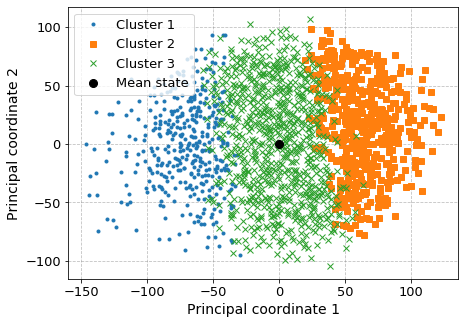

In [90]:
n_components = 3
output_file = get_kmeans_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, N_INIT)

kmeans_ds = xr.open_dataset(output_file)

eofs_reference_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))

kmeans_ds = sort_states(kmeans_ds, eofs_reference_file)

n_samples = kmeans_ds.sizes[TIME_NAME]

fig = plt.figure(figsize=(7, 5))
ax = plt.gca()

markers = itertools.cycle(('.', 's', 'x', 'o', '+'))
for i in range(n_components):
    mask = kmeans_ds['weights'].values[i] != 0
    
    cluster_embedding = mds_2d_scos['embedding'].isel({TIME_NAME: slice(0, n_samples)}).values[mask]
    
    ax.plot(cluster_embedding[:, 0], cluster_embedding[:, 1], marker=next(markers), ls='none',
            label='Cluster {:d}'.format(i + 1))

ax.plot(mds_2d_scos['origin'].sel(component=0), mds_2d_scos['origin'].sel(component=1), 'ko', markersize=8,
        label='Mean state')

ax.grid(ls='--', color='gray', alpha=0.5)
ax.legend(fontsize=13)

ax.set_xlabel('Principal coordinate 1', fontsize=14)
ax.set_ylabel('Principal coordinate 2', fontsize=14)
ax.axes.tick_params(labelsize=13)

output_file = os.path.join(PLOTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.kmeans.{}.k{:d}.n_init{:d}.{}_gap.mds.pdf'.format(
    BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS,
    n_components, N_INIT, REFERENCE))

plt.savefig(output_file, bbox_inches='tight')

plt.show()

plt.close()

kmeans_ds.close()


In [33]:
mds_3d_scos = run_mds(sst_anom_da, n_components=3, lat_weights='scos')

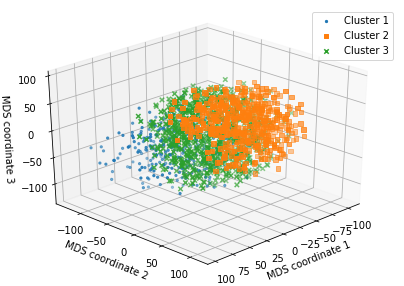

In [58]:
n_components = 3
output_file = get_kmeans_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, N_INIT)

kmeans_ds = xr.open_dataset(output_file)

eofs_reference_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))

kmeans_ds = sort_states(kmeans_ds, eofs_reference_file)

n_samples = kmeans_ds.sizes[TIME_NAME]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

markers = itertools.cycle(('.', 's', 'x', 'o', '+'))
for i in range(n_components):
    mask = kmeans_ds['weights'].values[i] != 0
    
    cluster_embedding = mds_3d_scos['embedding'].isel({TIME_NAME: slice(0, n_samples)}).values[mask]
    
    ax.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], cluster_embedding[:, 2],
               marker=next(markers), label='Cluster {:d}'.format(i + 1))
    
ax.grid(ls='--', color='gray', alpha=0.5)
ax.legend()

ax.view_init(elev=30, azim=45)

ax.set_xlabel('MDS coordinate 1')
ax.set_ylabel('MDS coordinate 2')
ax.set_zlabel('MDS coordinate 3')

plt.show()

plt.close()

kmeans_ds.close()

In [60]:
def run_tsne(da, lat_weights=LAT_WEIGHTS, n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0,
             n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean',
             init='random', verbose=0, random_state=None, method='barnes_hut', angle=0.5,
             n_jobs=None, lat_name=LAT_NAME, sample_dim=TIME_NAME):
    """Run t-SNE on given data."""

    feature_dims = [d for d in da.dims if d != sample_dim]
    original_shape = [da.sizes[d] for d in da.dims if d != sample_dim]

    # Get requested latitude weights
    weights = get_latitude_weights(da, lat_weights=lat_weights,
                                   lat_name=lat_name)

    # Convert input data array to plain 2D array
    flat_data = weight_and_flatten_data(da, weights=weights, sample_dim=sample_dim)

    n_samples, n_features = flat_data.shape

    # Remove any features/columns with missing data
    missing_features = np.any(np.isnan(flat_data), axis=0)
    valid_data = flat_data[:, np.logical_not(missing_features)]

    tsne = TSNE(n_components=n_components, perplexity=perplexity,
                early_exaggeration=early_exaggeration, learning_rate=learning_rate,
                n_iter=n_iter, n_iter_without_progress=n_iter_without_progress,
                min_grad_norm=min_grad_norm, metric=metric, init=init, verbose=verbose,
                random_state=random_state, method=method, angle=angle, n_jobs=n_jobs).fit(valid_data)
    
    embedding_da = xr.DataArray(
        tsne.embedding_,
        coords={sample_dim: da[sample_dim], 'component': np.arange(n_components)},
        dims=[sample_dim, 'component'])
    
    tsne_ds = xr.Dataset(data_vars={'embedding': embedding_da})
    tsne_ds.attrs['kl_divergence'] = '{:16.8e}'.format(tsne.kl_divergence_)
    tsne_ds.attrs['n_iter'] = '{:d}'.format(tsne.n_iter_)

    return tsne_ds

In [61]:
perplexities = [5, 10, 30, 50, 100, 200]
tsne_2d_scos_results = []
for p in perplexities:
    tsne_2d_scos_results.append(run_tsne(sst_anom_da, lat_weights='scos', n_components=2,
                                         perplexity=p, learning_rate=50.0, n_iter=20000, verbose=1))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1788 samples in 2.227s...
[t-SNE] Computed neighbors for 1788 samples in 105.709s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1788
[t-SNE] Computed conditional probabilities for sample 1788 / 1788
[t-SNE] Mean sigma: 19.070481
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.353554
[t-SNE] KL divergence after 20000 iterations: 0.957057
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1788 samples in 2.198s...
[t-SNE] Computed neighbors for 1788 samples in 105.206s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1788
[t-SNE] Computed conditional probabilities for sample 1788 / 1788
[t-SNE] Mean sigma: 20.885806
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.620728
[t-SNE] KL divergence after 20000 iterations: 1.246783
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1788 samples in 2.119s...
[t-SNE] Computed neighbors for 1788 samp

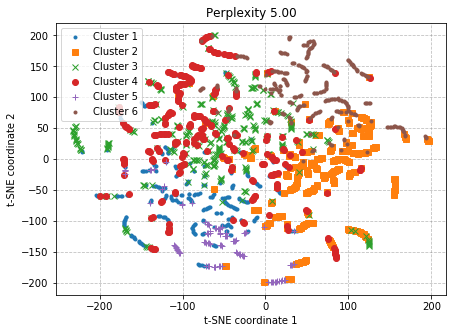

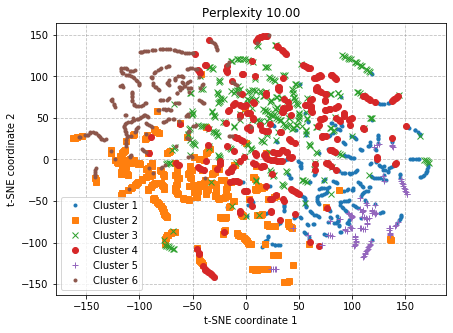

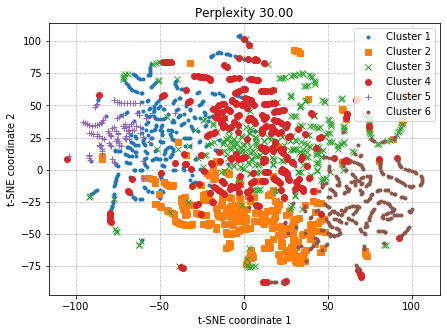

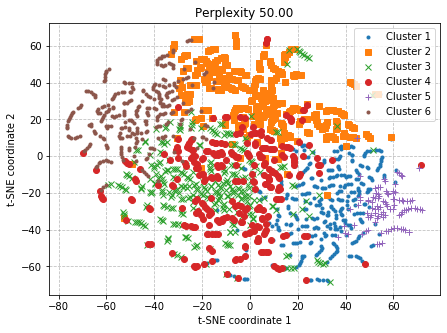

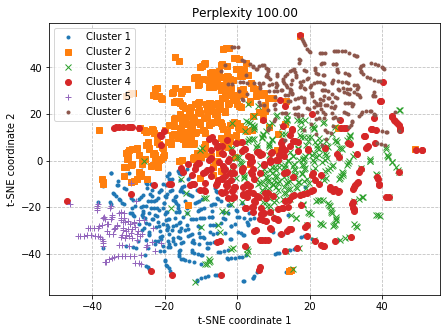

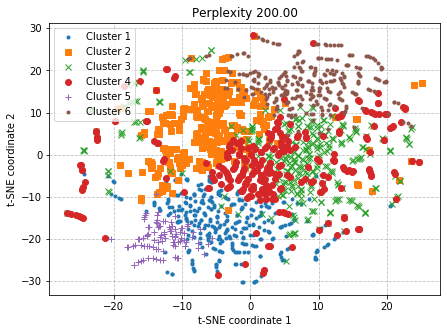

In [65]:
n_components = 6
output_file = get_kmeans_output_filename(SST_ANOM_INPUT_FILE, LAT_WEIGHTS, n_components, N_INIT)

kmeans_ds = xr.open_dataset(output_file)

eofs_reference_file = os.path.join(RESULTS_DIR, 'HadISST_sst.anom.{:d}_{:d}.trend_order{:d}.pca.{}.k{:d}.nc'.format(
        BASE_PERIOD_START_YEAR, BASE_PERIOD_END_YEAR, ANOMALY_TREND_ORDER, LAT_WEIGHTS, n_components))

kmeans_ds = sort_states(kmeans_ds, eofs_reference_file)

n_samples = kmeans_ds.sizes[TIME_NAME]

for i, p in enumerate(perplexities):

    tsne_2d_scos = tsne_2d_scos_results[i]

    fig = plt.figure(figsize=(7, 5))
    ax = plt.gca()

    markers = itertools.cycle(('.', 's', 'x', 'o', '+'))

    for i in range(n_components):
        mask = kmeans_ds['weights'].values[i] != 0
    
        cluster_embedding = tsne_2d_scos['embedding'].isel({TIME_NAME: slice(0, n_samples)}).values[mask]
    
        ax.plot(cluster_embedding[:, 0], cluster_embedding[:, 1], marker=next(markers), ls='none',
                label='Cluster {:d}'.format(i + 1))
    
    ax.grid(ls='--', color='gray', alpha=0.5)
    ax.legend()

    ax.set_xlabel('t-SNE coordinate 1')
    ax.set_ylabel('t-SNE coordinate 2')
    ax.set_title('Perplexity {:.2f}'.format(p))

    plt.show()

    plt.close()

kmeans_ds.close()